<a href="https://colab.research.google.com/github/Najme-naseri/MNISTwithCNN/blob/main/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
#use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
#load train data and transform it to a tensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
#load test data and transform it to a tensor
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
#print train data size
print(train_data.data.size())
print(train_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


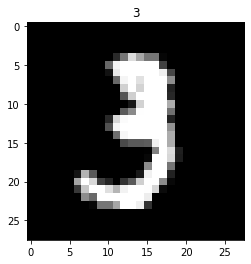

In [ ]:
#show one example of train data
import matplotlib.pyplot as plt
plt.imshow(train_data.data[10], cmap='gray')
plt.title('%i' % train_data.targets[10])
plt.show()

In [ ]:
print(type(train_data.data[10]))
print(train_data.data[10])

<class 'torch.Tensor'>
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118, 219,
         166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254, 254,
         254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,

In [ ]:
from torch.utils.data import DataLoader
#load the data in batches and shuffle it to avoid overfitting

#We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, 
#and supports automatic batching, sampling, shuffling and multiprocess data loading. 

loaders = {
    'train' : DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f8395c5d880>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f8395c4ce80>}

In [ ]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
#loss function
loss_func = nn.CrossEntropyLoss() 
#optimization  
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   


In [ ]:
from torch.autograd import Variable
num_epochs = 5
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        
        pass
    
    
    pass
train(num_epochs, cnn, loaders)

Epoch [1/5], Step [100/600], Loss: 0.1154
Epoch [1/5], Step [200/600], Loss: 0.1194
Epoch [1/5], Step [300/600], Loss: 0.1061
Epoch [1/5], Step [400/600], Loss: 0.1272
Epoch [1/5], Step [500/600], Loss: 0.0199
Epoch [1/5], Step [600/600], Loss: 0.0811
Epoch [2/5], Step [100/600], Loss: 0.0606
Epoch [2/5], Step [200/600], Loss: 0.0628
Epoch [2/5], Step [300/600], Loss: 0.0482
Epoch [2/5], Step [400/600], Loss: 0.0486
Epoch [2/5], Step [500/600], Loss: 0.0504
Epoch [2/5], Step [600/600], Loss: 0.0954
Epoch [3/5], Step [100/600], Loss: 0.1030
Epoch [3/5], Step [200/600], Loss: 0.0643
Epoch [3/5], Step [300/600], Loss: 0.0411
Epoch [3/5], Step [400/600], Loss: 0.0134
Epoch [3/5], Step [500/600], Loss: 0.0912
Epoch [3/5], Step [600/600], Loss: 0.0094
Epoch [4/5], Step [100/600], Loss: 0.0057
Epoch [4/5], Step [200/600], Loss: 0.0627
Epoch [4/5], Step [300/600], Loss: 0.0734
Epoch [4/5], Step [400/600], Loss: 0.0474
Epoch [4/5], Step [500/600], Loss: 0.1368
Epoch [4/5], Step [600/600], Loss:

In [ ]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
            print(accuracy)
    
test()

0.99
0.99
1.0
0.99
1.0
0.97
0.99
0.98
0.99
0.99
0.98
0.95
0.98
1.0
0.99
0.99
0.99
0.97
1.0
0.96
0.98
1.0
0.99
0.98
0.97
0.98
0.99
0.98
0.99
0.98
1.0
0.97
0.97
0.98
0.98
0.98
1.0
0.99
0.96
1.0
1.0
0.99
0.99
0.98
0.98
0.99
0.99
1.0
0.98
0.96
1.0
0.97
0.99
0.97
1.0
0.98
0.99
0.99
0.97
0.99
1.0
0.99
0.96
0.96
0.96
0.98
0.98
0.99
0.99
0.98
0.96
0.99
0.96
0.98
0.95
0.99
0.99
1.0
0.98
0.98
0.98
0.98
0.98
0.96
0.99
0.99
0.99
0.99
0.99
0.99
0.94
0.96
0.97
0.98
0.99
0.99
0.98
0.99
0.98
0.98
